# Notebook for Train Cyclical Stochastic Gradient MCMC with Synthetic Dataset 

Centro de Investigación en Matemáticas, A.C.  (CIMAT)  
mario.canche@cimat.mx  
23/April/2021

## First Conect with Personal Drive

In [1]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

/content
drive  sample_data


In [3]:
# Cambiamos de directorio al Drive
import os
os.chdir("drive/My Drive/PruebasCOLAB2/OF-PathPred/tests")
!ls

test_dataset.py  test_loo.py		      test_rnns.ipynb
test_heatmap.py  test_opticalflow.py	      trainBDL_loop.ipynb
test_loo.ipynb	 test_raycastingobstacles.py


## Later, Train Model Cyclical SG-MCMC

In [4]:
# Imports
import sys,os
''' TF_CPP_MIN_LOG_LEVEL
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printeds
3 = INFO, WARNING, and ERROR messages are not printed
'''
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('../')
import math,numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
print('[INF] Tensorflow version: ',tf.__version__)
tf.test.gpu_device_name()
# Important imports
import path_prediction.batches_data
import matplotlib.pyplot as plt
from path_prediction.model import TrajectoryEncoderDecoder, Model_Parameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from path_prediction.datasets_utils import setup_loo_experiment_synthec, get_testing_batch_synthec
from path_prediction.plot_utils import plot_training_data,plot_training_results
from path_prediction.testing_utils import evaluation_minadefde,evaluation_qualitative,plot_comparisons_minadefde
from path_prediction.training_utils import BDL_training_loop
from path_prediction.training_utils import Experiment_Parameters

[INF] Tensorflow version:  2.4.1


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices)>0:
    print('[INF] Using GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("[INF] Using CPU")

[INF] Using GPU Device: /device:GPU:0


In [6]:
# Load the default parameters
experiment_parameters = Experiment_Parameters(add_social=False,add_kp=False,obstacles=False)

#dataset_dir   = "../datasets/"
#dataset_names = ['eth-hotel','eth-univ','ucy-zara01','ucy-zara02','ucy-univ']

dataset_dir   = "../datasets_synthetic/"
dataset_names = ['testing_toy.txt','training_toy.txt']

In [7]:
!ls

test_dataset.py  test_loo.py		      test_rnns.ipynb
test_heatmap.py  test_opticalflow.py	      trainBDL_loop.ipynb
test_loo.ipynb	 test_raycastingobstacles.py


In [8]:
# Seed for Random Numpy
seed = 0
# Load the dataset and perform the split
idTest = 0
training_data,validation_data,test_data = setup_loo_experiment_synthec('.',dataset_dir,dataset_names,idTest,experiment_parameters,use_pickled_data=False,seed=seed)

[INF] Testing/validation dataset: ['testing_toy.txt']
[INF] Training datasets: ['training_toy.txt']
[INF] Extracting data from the datasets
[INF] Sequence length (observation+prediction): 20
[INF] Reading ../datasets_synthetic/testing_toy.txt
[INF] Total number of frames:  40000
[INF] Total number of trajectories in this dataset:  12000
[INF] Total number of sample sequences:  12000
[INF] Sequence length (observation+prediction): 20
[INF] Reading ../datasets_synthetic/training_toy.txt
[INF] Total number of frames:  40000
[INF] Total number of trajectories in this dataset:  12000
[INF] Total number of sample sequences:  12000
[INF] Training data: 10800
[INF] Test data: 12000
[INF] Validation data: 1200


In [9]:
#############################################################
# Model parameters
model_parameters = Model_Parameters(add_attention=True,add_kp=experiment_parameters.add_kp,add_social=experiment_parameters.add_social,output_representation=experiment_parameters.output_representation)
model_parameters.num_epochs     = 35
model_parameters.output_var_dirs= 0
model_parameters.is_mc_dropout  = False # poner a False
model_parameters.initial_lr     = 0.085
model_parameters.batch_size     = 256

model_parameters.beta = 0.80 # Thresh
model_parameters.datasize = 10800 # datasize of training
model_parameters.M = 4 # number of cycles
model_parameters.alpha = 1
model_parameters.temperature = 1./model_parameters.datasize


In [10]:
# Get the necessary data
train_data = tf.data.Dataset.from_tensor_slices(training_data)
val_data   = tf.data.Dataset.from_tensor_slices(validation_data)
test_data  = tf.data.Dataset.from_tensor_slices(test_data)


In [11]:
# Form batches
batched_train_data = train_data.batch(model_parameters.batch_size)
batched_val_data   = val_data.batch(model_parameters.batch_size)
batched_test_data  = test_data.batch(model_parameters.batch_size)


In [12]:
# Seed for Random Tensorflow
tf.random.set_seed(0)

# Model
tj_enc_dec = TrajectoryEncoderDecoder(model_parameters)

[INF] Initialization
Model: "trajectory_context_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observed_trajectory (InputLa [(None, 8, 2)]            0         
_________________________________________________________________
trajectory_encoder (Trajecto [(None, 8, 256), [(None,  919936    
_________________________________________________________________
tf.stack (TFOpLambda)        (None, 1, 8, 256)         0         
Total params: 919,936
Trainable params: 919,936
Non-trainable params: 0
_________________________________________________________________
Model: "observed_trajectory_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observed_trajectory_h (Input [(None, 256)]             0         
_________________________________________________________________
observed_dense (Dense)       (None, 64)

In [13]:
# Checkpoints
checkpoint_dir   = './training_checkpoints'
checkpoint_prefix= os.path.join(checkpoint_dir, "ckpt")
checkpoint       = tf.train.Checkpoint(optimizer=tj_enc_dec.optimizer,
                                        encoder=tj_enc_dec.enc,
                                        decoder=tj_enc_dec.dec,
                                        enctodec=tj_enc_dec.enctodec,
                                        obs_classif=tj_enc_dec.obs_classif)

  0%|          | 0/43 [00:00<?, ?it/s]

[INF] Training the model
Epoch 1.


100%|##########| 43/43 [01:22<00:00,  1.92s/it]
0it [00:00, ?it/s]

[TRN] Epoch 1. Training loss 705.1249


5it [00:08,  1.63s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 1. Validation loss 1555.0845


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 1. Validation mADE 2182.4287
Epoch 2.


100%|##########| 43/43 [01:19<00:00,  1.85s/it]
0it [00:00, ?it/s]

[TRN] Epoch 2. Training loss 710.5731


5it [00:08,  1.61s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 2. Validation loss 1417.1194


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 2. Validation mADE 1987.0405
Epoch 3.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 3. Training loss 454.8540


5it [00:08,  1.61s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 3. Validation loss 820.7401


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 3. Validation mADE 1143.7321
Epoch 4.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 4. Training loss 344.5834


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 4. Validation loss 1022.4783


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 4. Validation mADE 1429.1323
Epoch 5.


100%|##########| 43/43 [01:19<00:00,  1.84s/it]
0it [00:00, ?it/s]

[TRN] Epoch 5. Training loss 250.6863


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 5. Validation loss 390.8260


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 5. Validation mADE 531.6566
Epoch 6.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 6. Training loss 156.6312


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 6. Validation loss 402.8309


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 6. Validation mADE 552.9832
Epoch 7.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 7. Training loss 74.4524


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 7. Validation loss 33.2622


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 7. Validation mADE 29.5105
Epoch 8.


100%|##########| 43/43 [01:18<00:00,  1.84s/it]
0it [00:00, ?it/s]

[TRN] Epoch 8. Training loss 38.0927


5it [00:08,  1.65s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 8. Validation loss 19.1518


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 8. Validation mADE 8.7028
Epoch 9.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 9. Training loss 86.2900


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 9. Validation loss 825.7621


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 9. Validation mADE 1150.5411
Epoch 10.


100%|##########| 43/43 [01:18<00:00,  1.81s/it]
0it [00:00, ?it/s]

[TRN] Epoch 10. Training loss 141.5585


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 10. Validation loss 464.2050


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 10. Validation mADE 639.4119
Epoch 11.


100%|##########| 43/43 [01:18<00:00,  1.81s/it]
0it [00:00, ?it/s]

[TRN] Epoch 11. Training loss 104.6846


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 11. Validation loss 440.5893


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 11. Validation mADE 606.0796
Epoch 12.


100%|##########| 43/43 [01:19<00:00,  1.85s/it]
0it [00:00, ?it/s]

[TRN] Epoch 12. Training loss 83.5760


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 12. Validation loss 207.8836


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 12. Validation mADE 277.1504
Epoch 13.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 13. Training loss 65.8454


5it [00:07,  1.56s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 13. Validation loss 280.9529


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 13. Validation mADE 380.4926
Epoch 14.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 14. Training loss 49.7676


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 14. Validation loss 108.4826


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 14. Validation mADE 136.6448
Epoch 15.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 15. Training loss 32.7556


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 15. Validation loss 88.9914


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 15. Validation mADE 109.0999
Epoch 16.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 16. Training loss 20.6875


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 16. Validation loss 17.8445


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 16. Validation mADE 5.8988
Epoch 17.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 17. Training loss 16.5997


5it [00:07,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 17. Validation loss 16.5620


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 17. Validation mADE 2.1640
Epoch 18.


100%|##########| 43/43 [01:19<00:00,  1.84s/it]
0it [00:00, ?it/s]

[TRN] Epoch 18. Training loss 53.3615


5it [00:07,  1.57s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 18. Validation loss 233.8886


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 18. Validation mADE 316.2358
Epoch 19.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 19. Training loss 91.7860


5it [00:07,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 19. Validation loss 522.7444


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 19. Validation mADE 723.6272
Epoch 20.


100%|##########| 43/43 [01:18<00:00,  1.81s/it]
0it [00:00, ?it/s]

[TRN] Epoch 20. Training loss 85.6360


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 20. Validation loss 149.0662


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 20. Validation mADE 194.9822
Epoch 21.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 21. Training loss 71.8316


5it [00:07,  1.56s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 21. Validation loss 408.9288


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 21. Validation mADE 562.0240
Epoch 22.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 22. Training loss 59.1969


5it [00:07,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 22. Validation loss 91.9866


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 22. Validation mADE 113.8865
Epoch 23.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 23. Training loss 43.2469


5it [00:07,  1.58s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 23. Validation loss 161.3122


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 23. Validation mADE 211.9531
Epoch 24.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 24. Training loss 29.8566


5it [00:08,  1.61s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 24. Validation loss 60.7159


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 24. Validation mADE 69.6584
Epoch 25.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 25. Training loss 18.5353


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 25. Validation loss 16.0698


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 25. Validation mADE 1.7466
Epoch 26.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 26. Training loss 15.9901


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 26. Validation loss 16.0361


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 26. Validation mADE 1.5491
Epoch 27.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 27. Training loss 72.3376


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 27. Validation loss 181.8626


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 27. Validation mADE 241.2538
Epoch 28.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 28. Training loss 89.6892


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 28. Validation loss 564.6691


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 28. Validation mADE 782.6745
Epoch 29.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 29. Training loss 81.8232


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 29. Validation loss 152.0591


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 29. Validation mADE 199.2594
Epoch 30.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 30. Training loss 64.0215


5it [00:08,  1.61s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 30. Validation loss 334.1861


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 30. Validation mADE 456.9043
Epoch 31.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 31. Training loss 51.1825


5it [00:07,  1.56s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 31. Validation loss 120.2347


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 31. Validation mADE 154.3898
Epoch 32.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 32. Training loss 37.0668


5it [00:07,  1.59s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 32. Validation loss 109.7718


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 32. Validation mADE 139.6319
Epoch 33.


100%|##########| 43/43 [01:18<00:00,  1.82s/it]
0it [00:00, ?it/s]

[TRN] Epoch 33. Training loss 24.7852


5it [00:07,  1.60s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 33. Validation loss 46.1299


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 33. Validation mADE 49.4848
Epoch 34.


100%|##########| 43/43 [01:18<00:00,  1.83s/it]
0it [00:00, ?it/s]

[TRN] Epoch 34. Training loss 16.2795


5it [00:07,  1.56s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 34. Validation loss 15.5175


  0%|          | 0/43 [00:00<?, ?it/s]

[TRN] Epoch 34. Validation mADE 0.0609
Epoch 35.


100%|##########| 43/43 [01:19<00:00,  1.84s/it]
0it [00:00, ?it/s]

[TRN] Epoch 35. Training loss 15.8703


5it [00:08,  1.61s/it]
  0%|          | 0/5 [00:00<?, ?it/s]

[TRN] Epoch 35. Validation loss 62.3874


100%|##########| 5/5 [00:10<00:00,  2.03s/it]


[TRN] Epoch 35. Validation mADE 83.5088


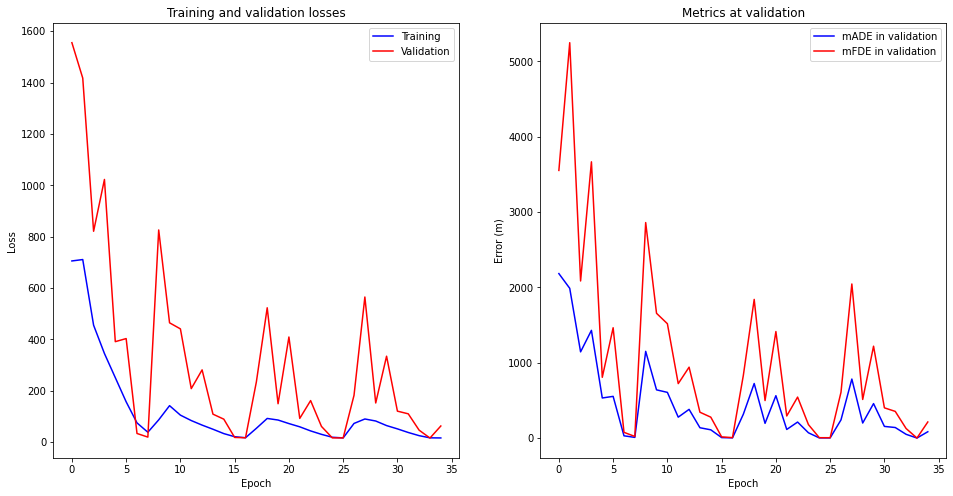

In [14]:
# Training
perform_training = True
plot_training    = True
if perform_training==True:
    print("[INF] Training the model")
    train_loss_results,val_loss_results,val_metrics_results,__ = BDL_training_loop(tj_enc_dec,batched_train_data,batched_val_data,model_parameters,checkpoint,checkpoint_prefix)
    if plot_training==True:
        plot_training_results(train_loss_results,val_loss_results,val_metrics_results)


In [15]:
# Testing
# Restoring the latest checkpoint in checkpoint_dir
print("[INF] Restoring last model")
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

[INF] Restoring last model


[INF] Qualitative testing


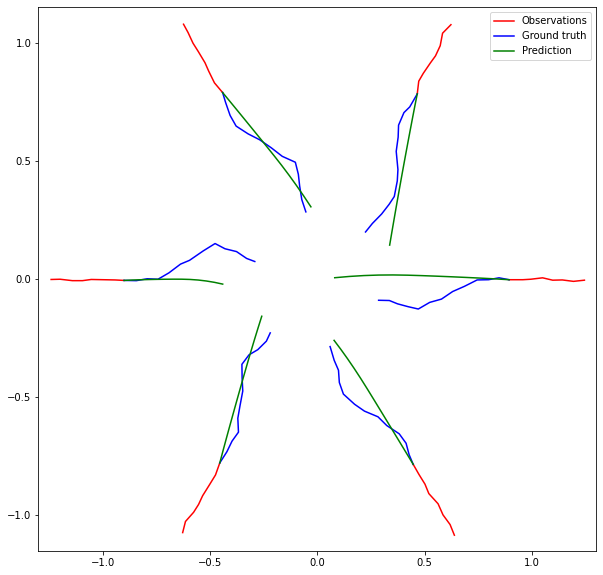

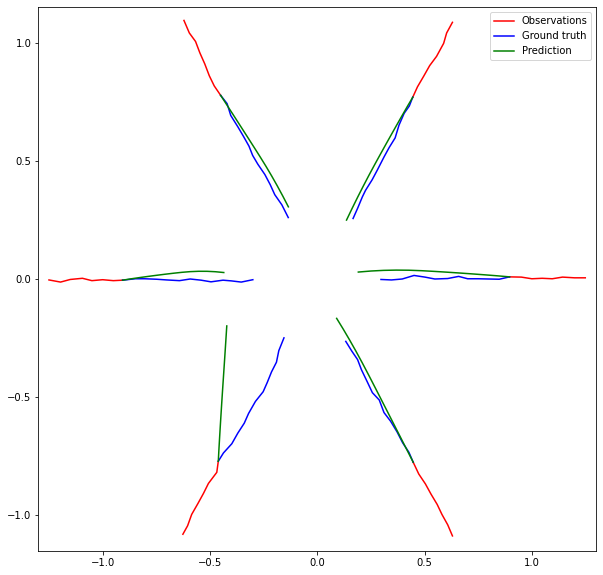

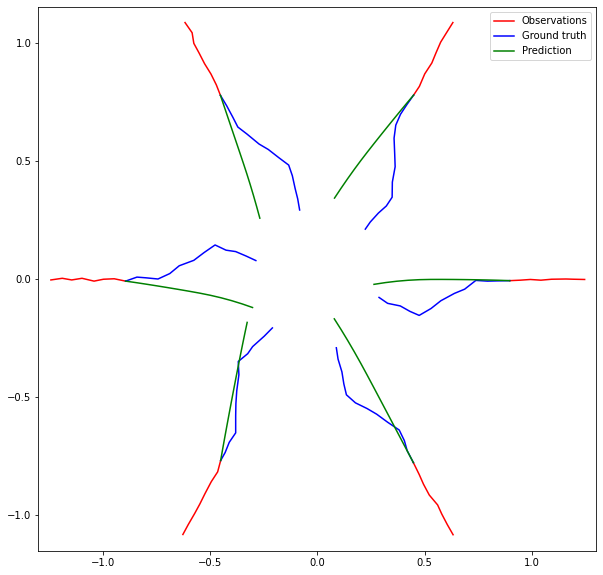

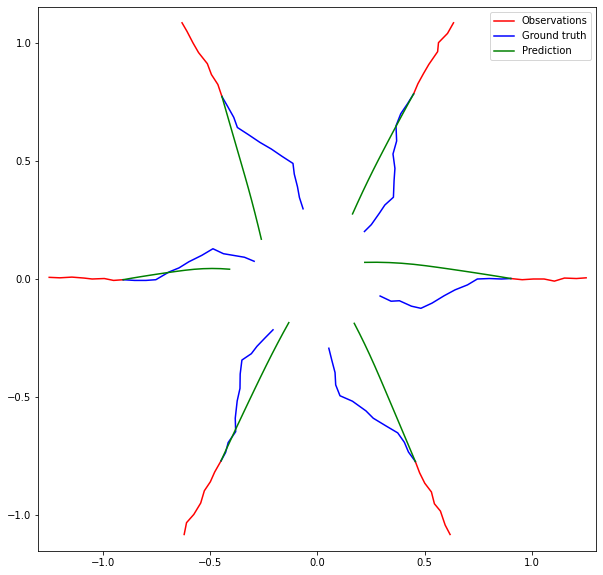

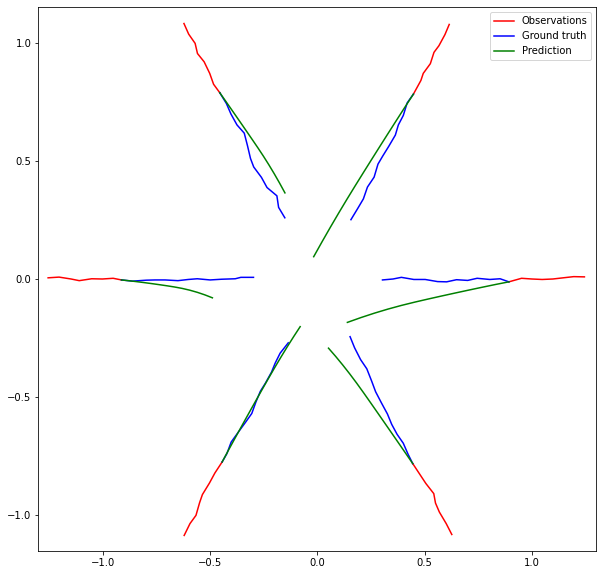

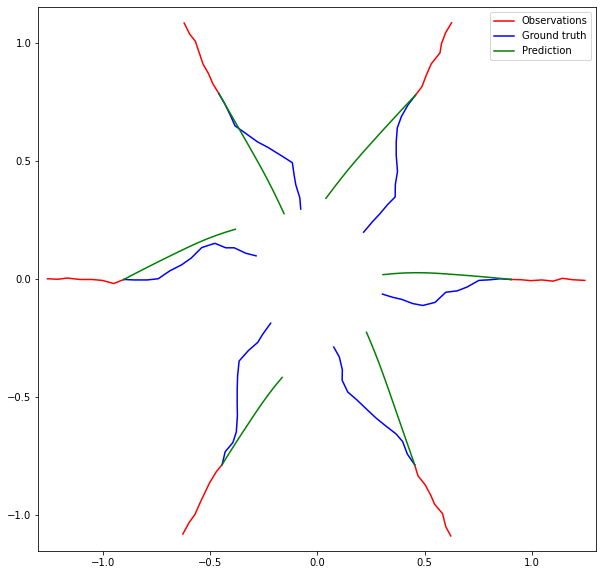

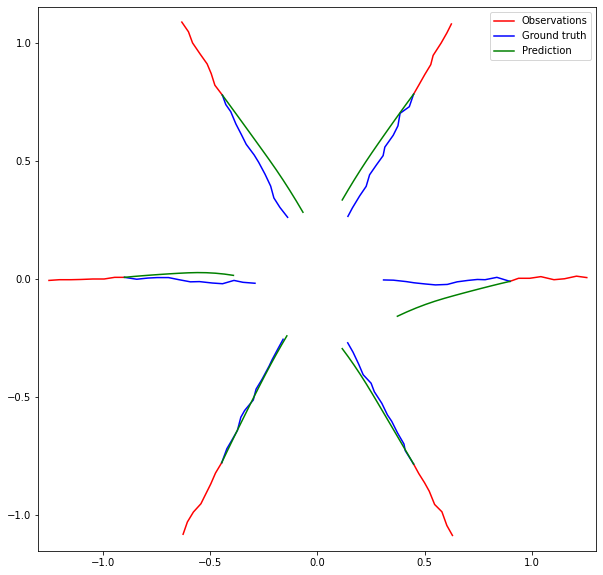

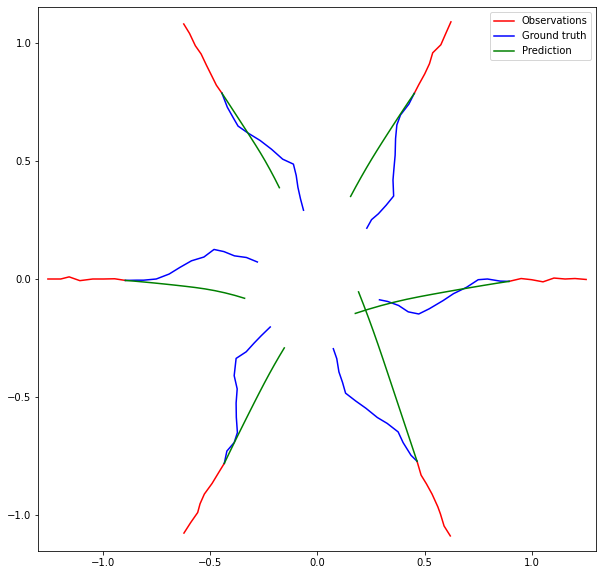

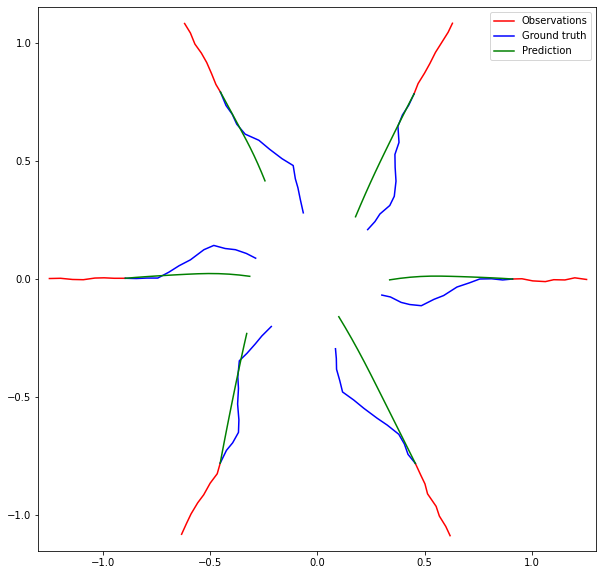

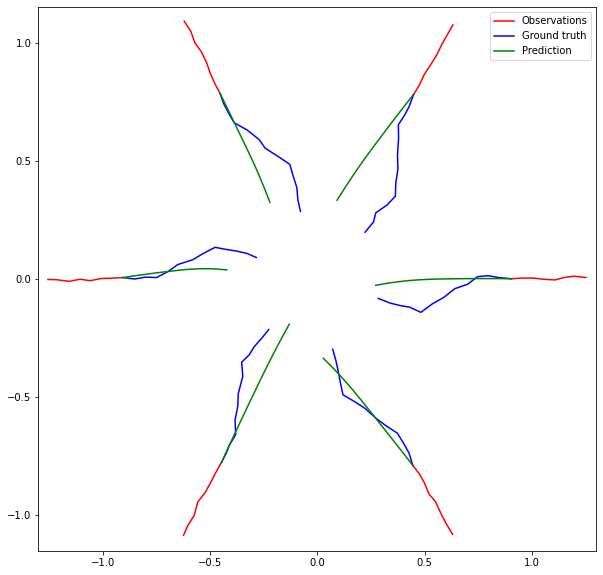

In [17]:
from path_prediction.testing_utils import predict_from_batch

# Qualitative testing
qualitative = True
if qualitative==True:
    print("[INF] Qualitative testing")
    for i in range(10):
        batch = get_testing_batch_synthec(test_data,dataset_dir+dataset_names[idTest])
        traj_obs,traj_gt,traj_pred,neighbors,__ = predict_from_batch(tj_enc_dec,batch,model_parameters)

        # Plots the trajectories
        plt.figure(figsize=(10,10))
        for j in range(len(traj_obs)):

            obs = traj_obs[j] # Trajectories Obs
            gt = np.vstack([traj_obs[j][-1], traj_gt[j]]) # Ground Thrue
            pred = np.vstack([traj_obs[j][-1], traj_pred[j].numpy()[0]]) # Trajectories Pred

            plt.plot(obs[:,0], obs[:,1],'r',label= 'Observations')
            plt.plot(gt[:,0], gt[:,1],'b',label= 'Ground truth')
            plt.plot(pred[:,0], pred[:,1],'g',label= 'Prediction')

            # Axes
            plt.xlim(-1.3,1.3)
            plt.ylim(-1.15,1.15)
        plt.legend(['Observations', 'Ground truth', 'Prediction'])
        plt.show()

## Finally, Load Weights from Cyclical SG-MCMC

In [18]:
import pickle
pickle_in = open('training_cSGMCMC_weights.pickle',"rb")
weights = pickle.load(pickle_in)

In [19]:
len(weights)

20

In [20]:
for www in weights:
    print(www[0], www[1][2][6])

0.0 [ 2.9983425 -2.6440554]
0.0 [ 2.9983358 -2.6440504]
0.0 [ 2.9983306 -2.6440458]
0.0 [ 2.9983287 -2.6440437]
0.0 [ 2.9983287 -2.6440437]
1.0 [ 1.0126942 -0.9067482]
1.0 [ 1.0126526 -0.9067101]
1.0 [ 1.0126289 -0.9066894]
1.0 [ 1.0126189  -0.90668046]
1.0 [ 1.0126171 -0.9066788]
2.0 [ 0.727843  -0.7153447]
2.0 [ 0.7278224 -0.7153248]
2.0 [ 0.7278125  -0.71531516]
2.0 [ 0.72780985 -0.71531254]
2.0 [ 0.72780985 -0.71531254]
3.0 [-0.01400063  0.00168969]
3.0 [-0.0139999  0.0016896]
3.0 [-0.01399975  0.00168976]
3.0 [-0.01399969  0.00168977]
3.0 [-0.01399968  0.00168977]


In [21]:
from matplotlib.lines import Line2D

colores = ["green",
           "yellow",
           "pink",
           "purple",
           "cyan",
           "orange",
           "olive",
           "brown",
           "grey",
           "black",
           "magenta",
           "white",
           "gold",
           "lightcoral",
           "darkred",
           "hotpink",
           "chocolate",
           "lightgray",
           "palegreen"
          ]

custom_lines = [Line2D([0],[0],color="purple",marker="s", markersize=7, linestyle=""),
                    Line2D([0],[0],color="red",lw=2),
                    Line2D([0],[0],color="blue",lw=2),
                    Line2D([0],[0],color="green",lw=2),
                    
                    Line2D([0],[0],color="yellow",lw=2),
                    Line2D([0],[0],color="pink",lw=2),
                    Line2D([0],[0],color="purple",lw=2),
                    Line2D([0],[0],color="cyan",lw=2),
                    Line2D([0],[0],color="orange",lw=2),
                    Line2D([0],[0],color="olive",lw=2),
                    Line2D([0],[0],color="brown",lw=2)
                   ]

[INF] Qualitative testing
batch:  (6, 8, 2)


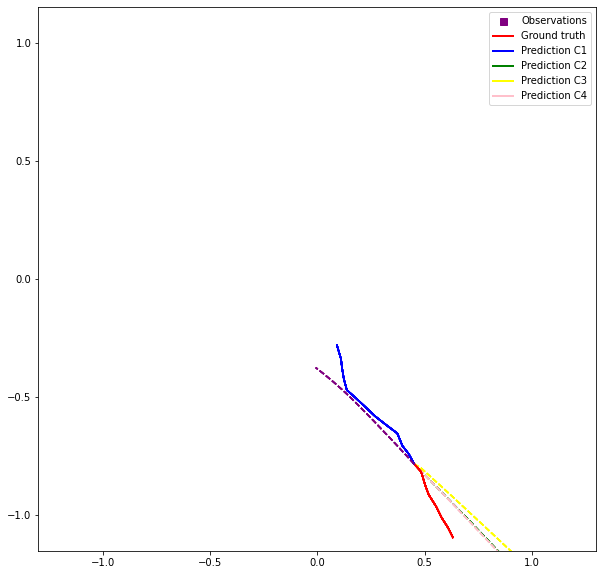

batch:  (6, 8, 2)


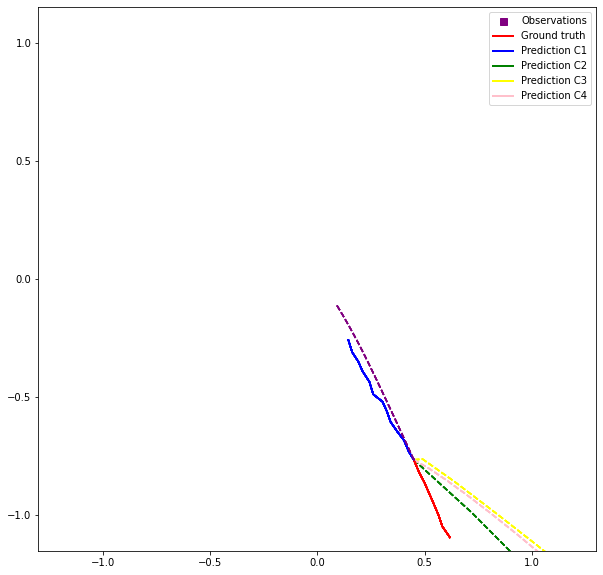

batch:  (6, 8, 2)


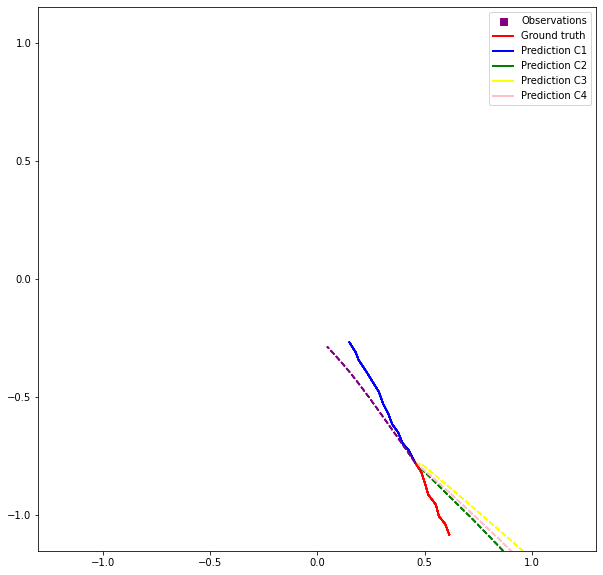

batch:  (6, 8, 2)


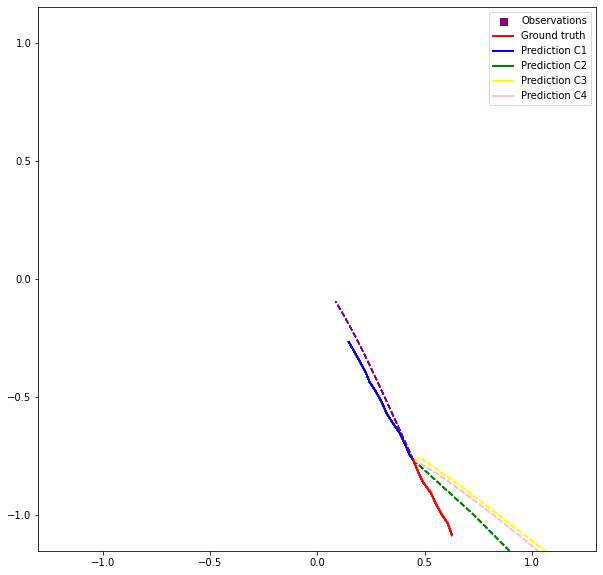

batch:  (6, 8, 2)


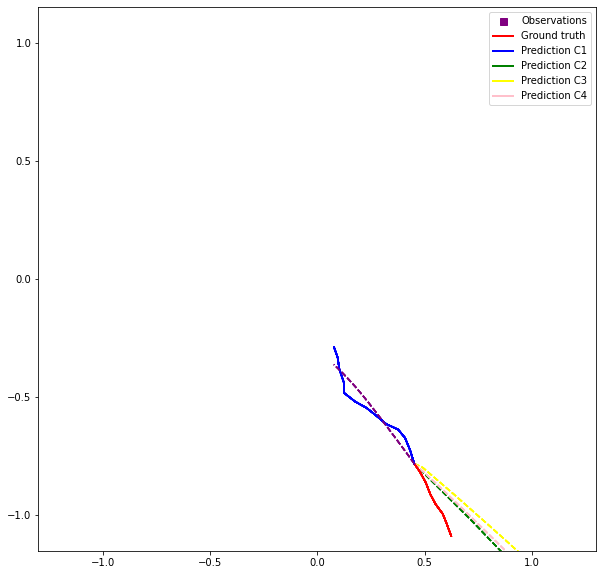

batch:  (6, 8, 2)


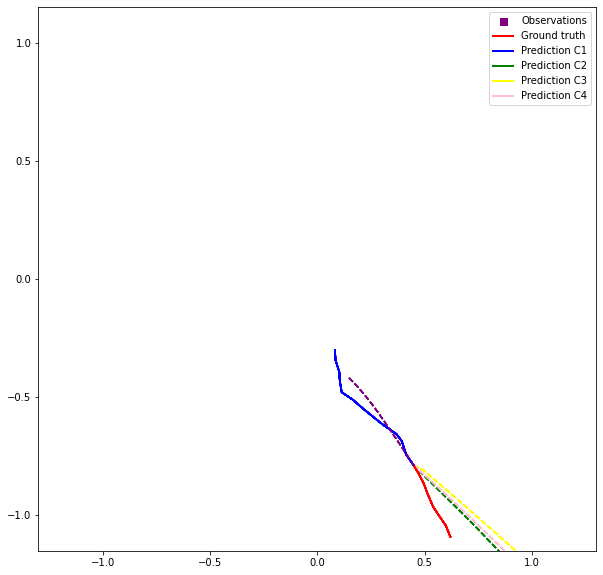

batch:  (6, 8, 2)


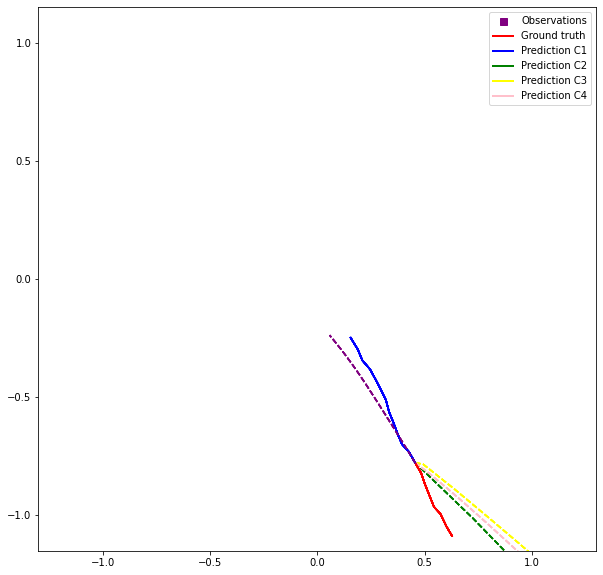

batch:  (6, 8, 2)


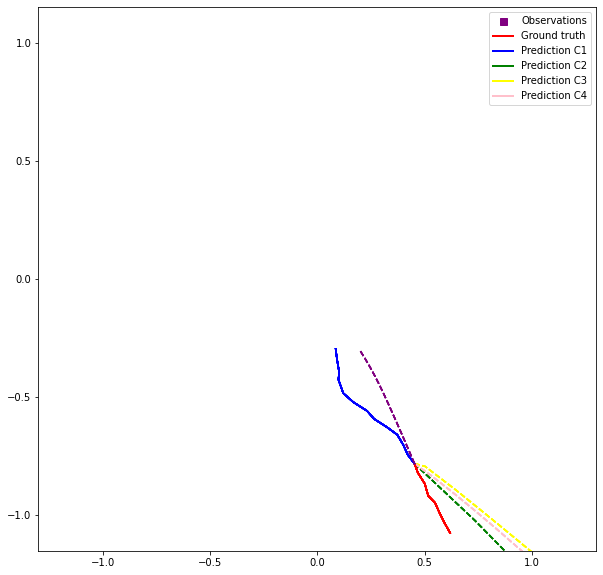

batch:  (6, 8, 2)


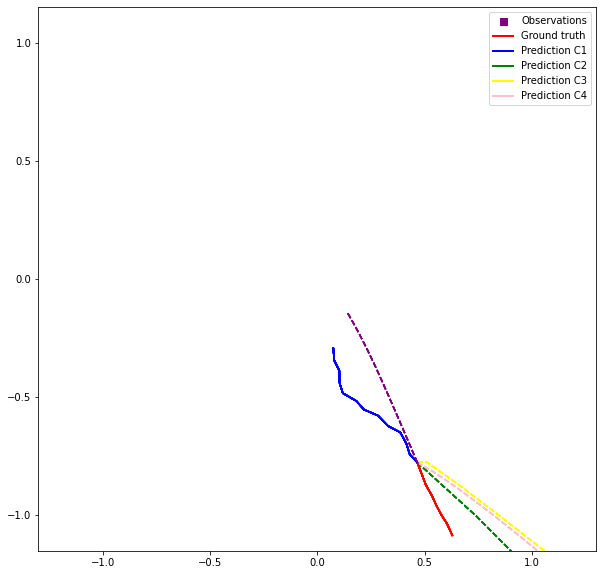

batch:  (6, 8, 2)


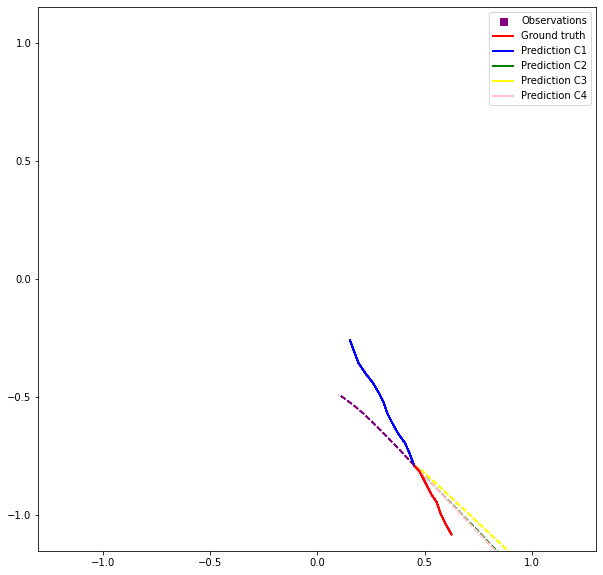

batch:  (6, 8, 2)


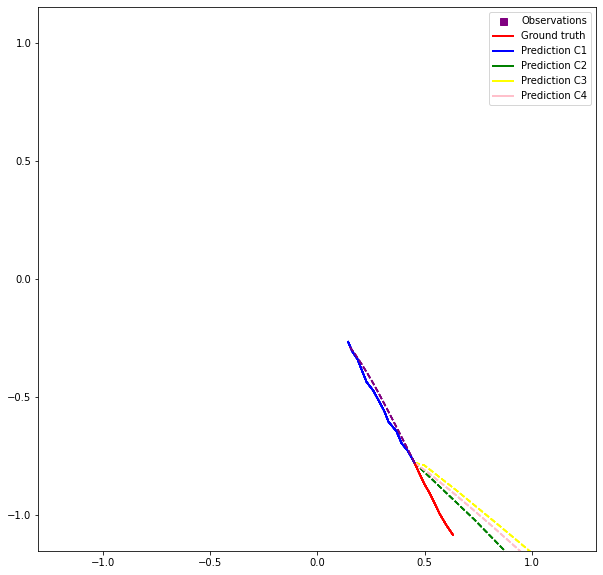

batch:  (6, 8, 2)


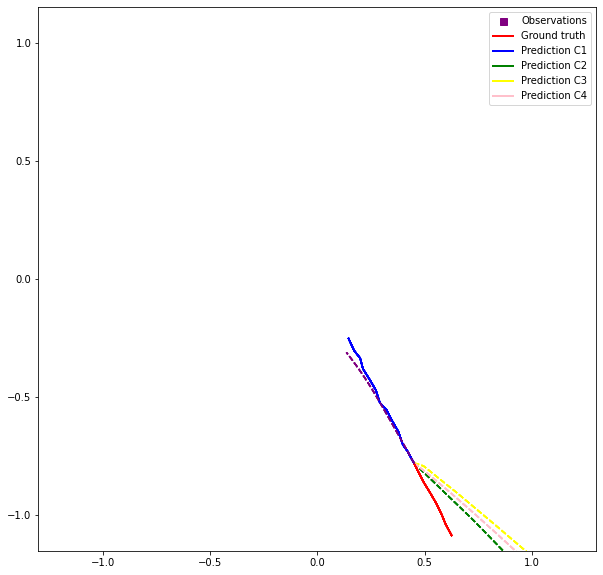

batch:  (6, 8, 2)


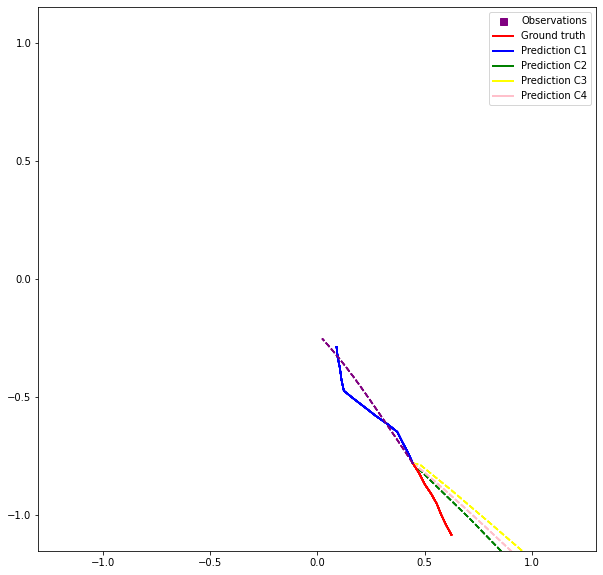

batch:  (6, 8, 2)


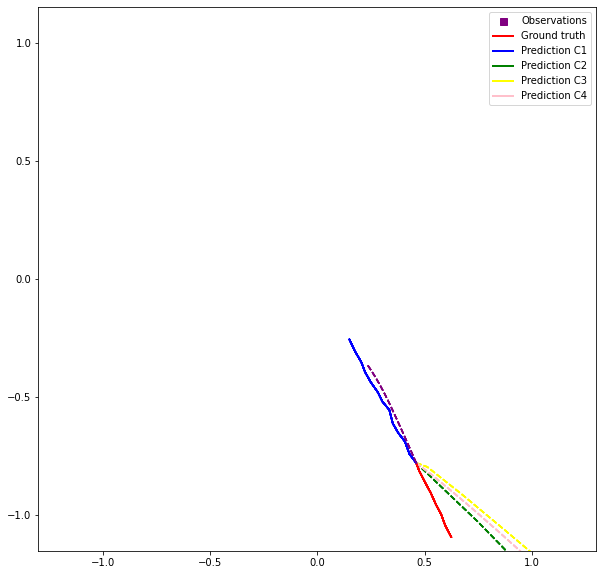

batch:  (6, 8, 2)


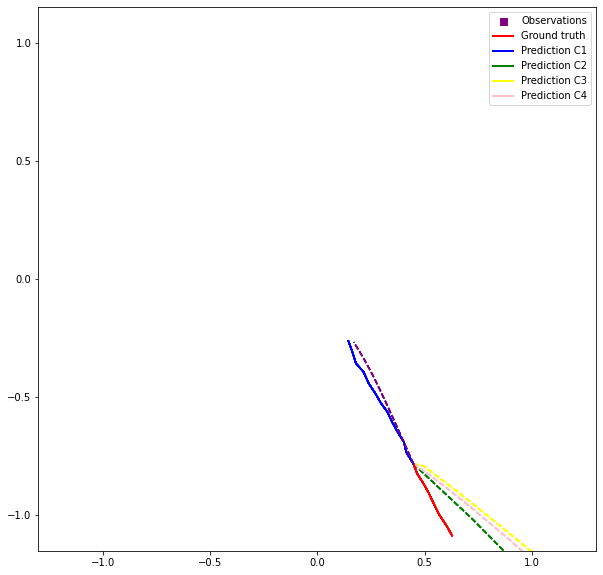

batch:  (6, 8, 2)


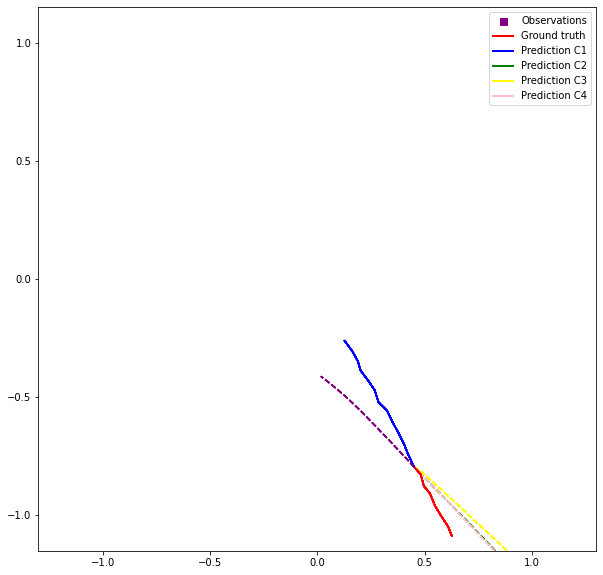

batch:  (6, 8, 2)


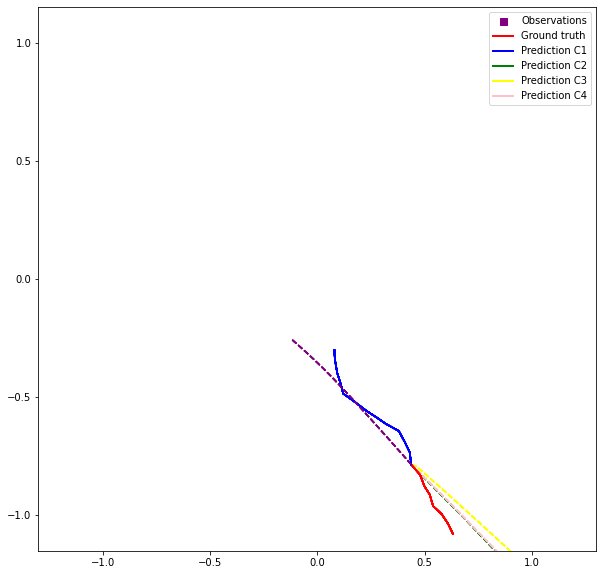

batch:  (6, 8, 2)


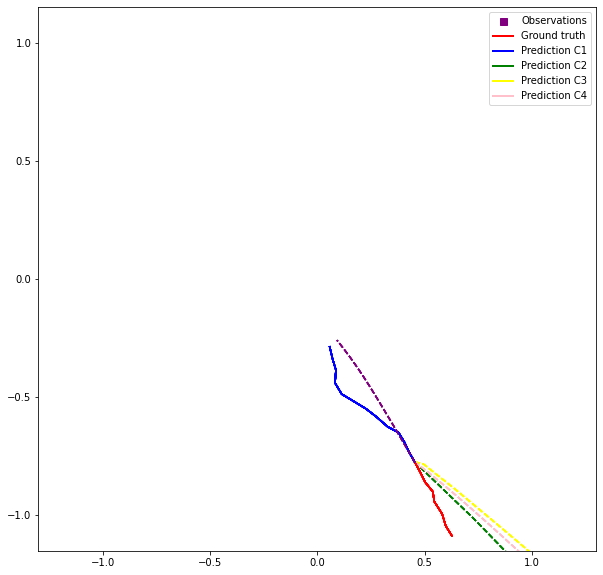

batch:  (6, 8, 2)


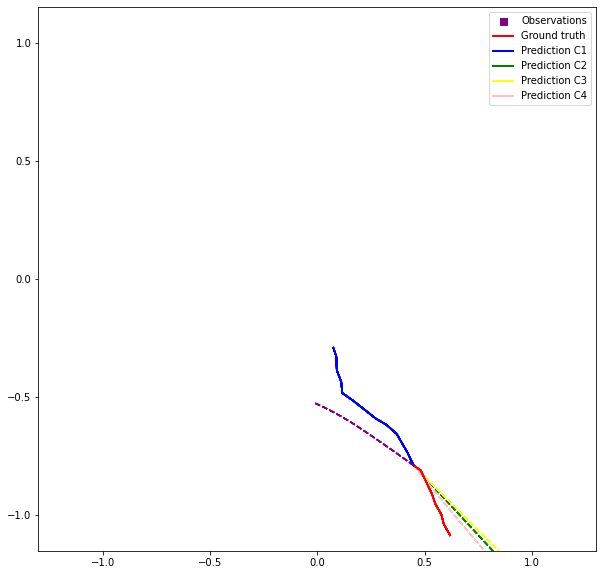

batch:  (6, 8, 2)


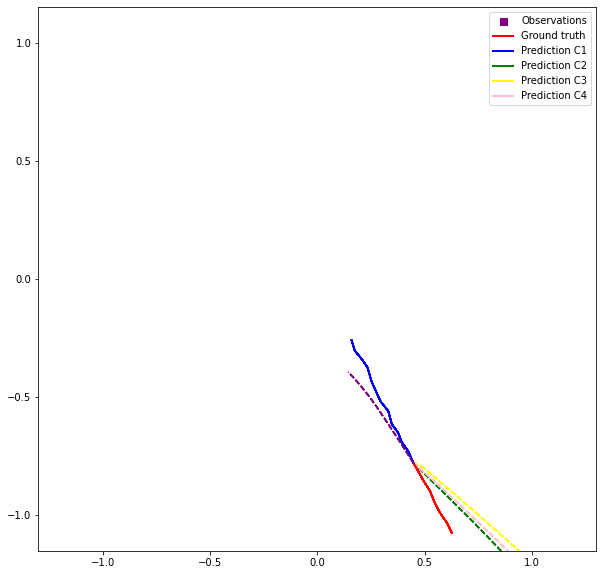

batch:  (6, 8, 2)


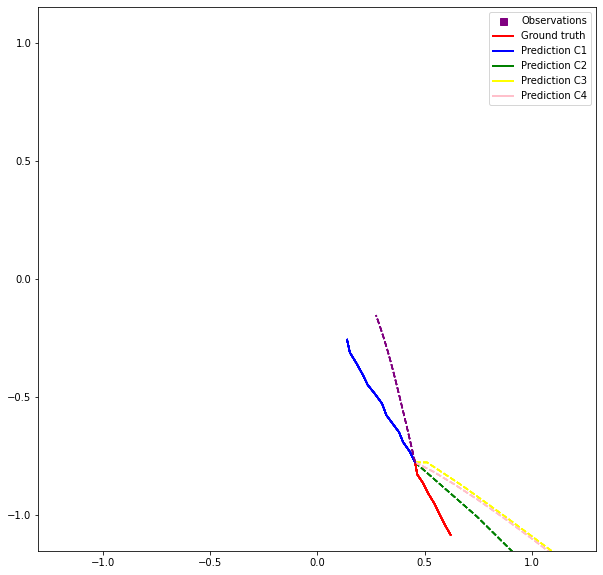

batch:  (6, 8, 2)


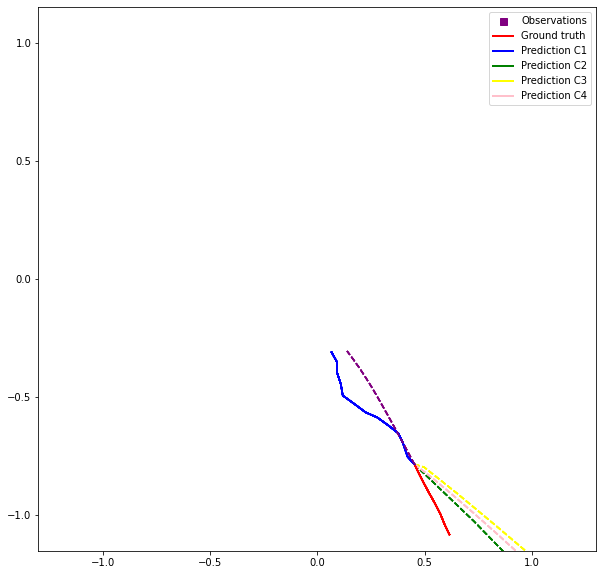

batch:  (6, 8, 2)


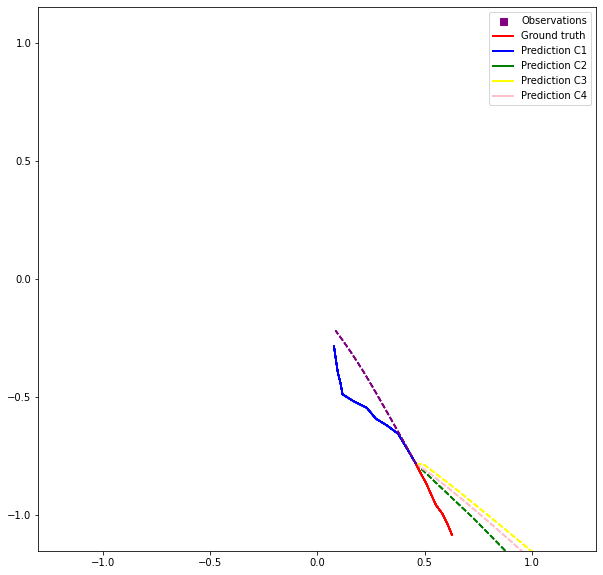

batch:  (6, 8, 2)


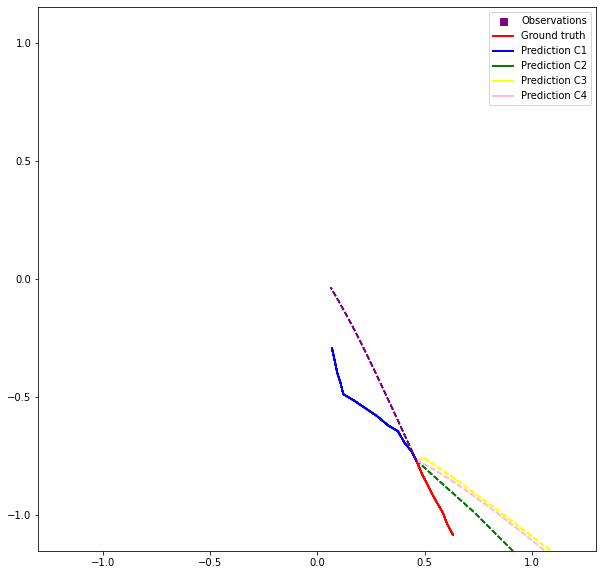

batch:  (6, 8, 2)


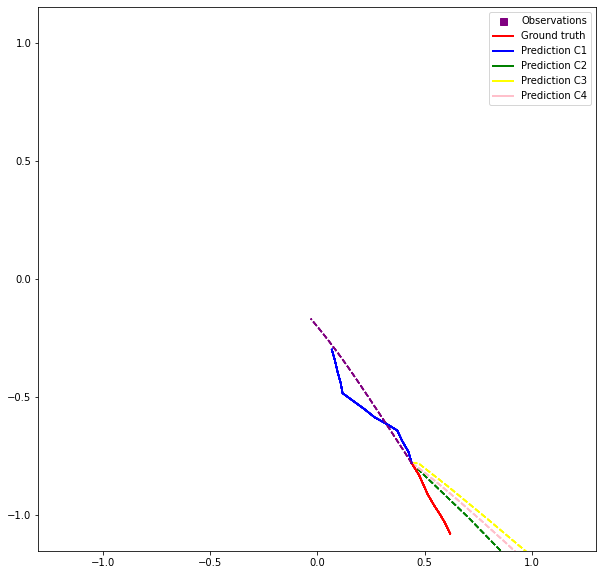

batch:  (6, 8, 2)


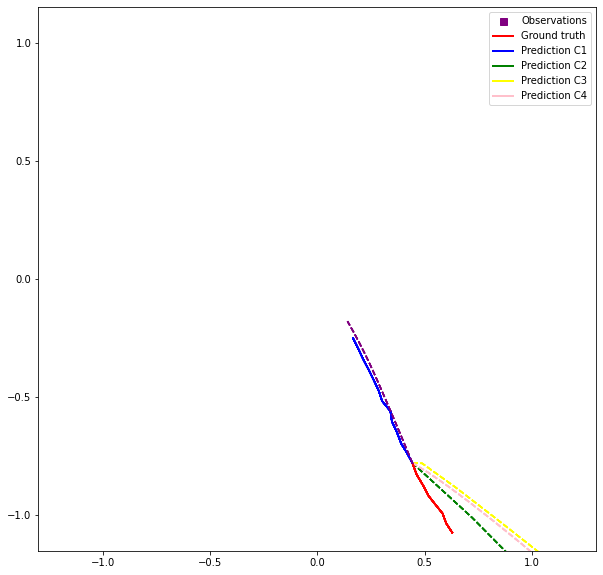

batch:  (6, 8, 2)


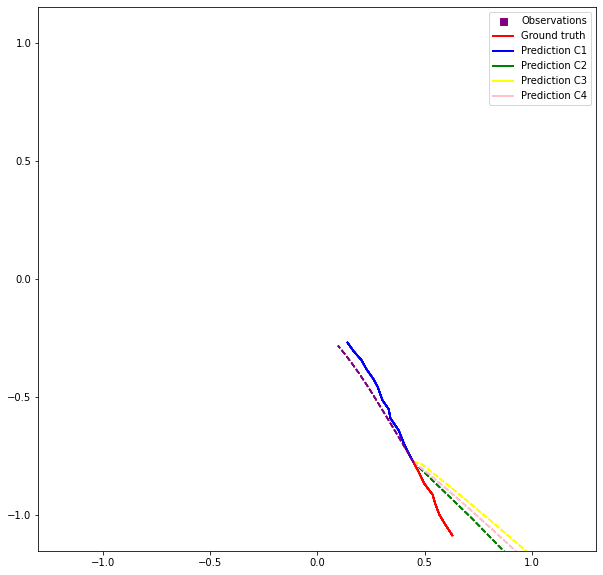

batch:  (6, 8, 2)


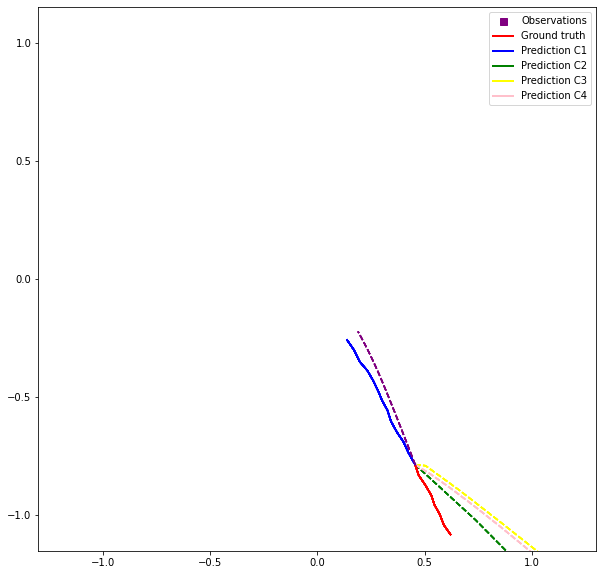

batch:  (6, 8, 2)


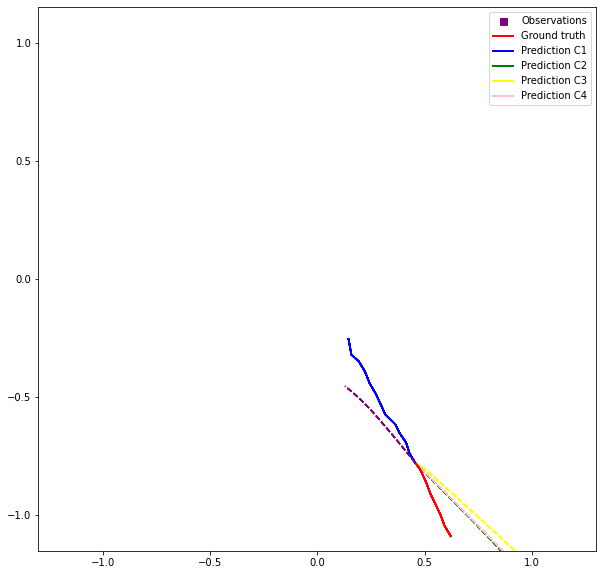

batch:  (6, 8, 2)


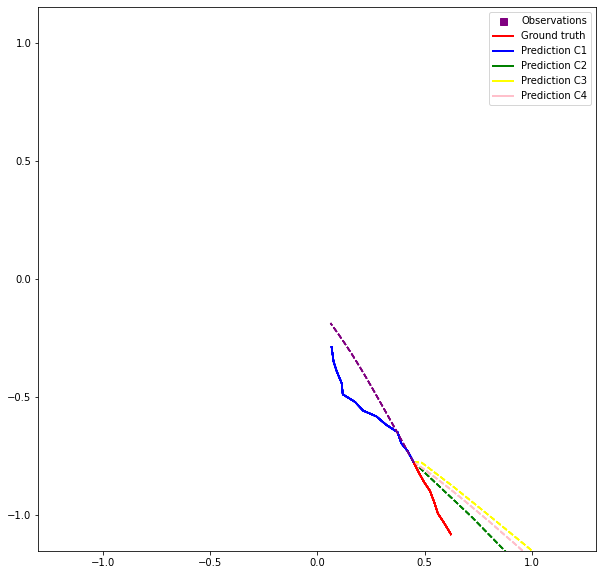

In [25]:
from path_prediction.plot_utils import plot_gt_preds, plot_background, plot_neighbors, plot_attention
from path_prediction.batches_data import get_batch
from path_prediction.traj_utils import relative_to_abs

#from testing_utils import compute_kde_nll2

# Qualitative testing
num_print_test = 30
model_parameters.output_var_dirs= 0
qualitative = True
if qualitative==True:
    print("[INF] Qualitative testing")
    for it in range(num_print_test):
        batch = get_testing_batch_synthec(test_data,dataset_dir+dataset_names[idTest])
        print("batch: ", batch['obs_traj'].shape)
        
        # Plot ground truth and predictions
        plt.subplots(1,1,figsize=(10,10))
        ax = plt.subplot(1,1,1)

        #-----------------------------------------------------------------------
        batch_inputs, batch_targets = get_batch(batch, model_parameters)

        # Iterate the diference weights for the model
        cont = 0
        for w_ind, weight in weights:
          # Perform prediction
          pred_traj, _ = tj_enc_dec.predict_cSGMCMC(batch_inputs,batch_targets.shape[1],weight)

          traj_obs      = []
          traj_gt       = []
          traj_pred     = []
          neighbors     = []
          # Cycle over the trajectories of the bach
          for i, (obs_traj_gt, pred_traj_gt, neighbors_gt) in enumerate(zip(batch["obs_traj"], batch["pred_traj"], batch["obs_neighbors"])):
              this_pred_out_abs_set = []

              if (pred_traj[i,0].shape[0] == model_parameters.pred_len):
                  this_pred_out     = pred_traj[i,0,:, :2]
                  # Convert it to absolute (starting from the last observed position)
                  this_pred_out_abs = relative_to_abs(this_pred_out, obs_traj_gt[-1])
                  this_pred_out_abs_set.append(this_pred_out_abs)
               #   print("this_pred_out_abs: ", this_pred_out_abs.shape)
              this_pred_out_abs_set = tf.stack(this_pred_out_abs_set,axis=0)
              # TODO: tensors instead of lists?
              # Keep all the trajectories
              traj_obs.append(obs_traj_gt)
              traj_gt.append(pred_traj_gt)
              traj_pred.append(this_pred_out_abs_set)
              neighbors.append(neighbors_gt)

          #-----------------------------------------------------------------------
          # Plot ground truth and predictions
          if cont == 0:
            pred_out = np.array(traj_pred)
          else:
            pred_out = np.concatenate([pred_out, np.array(traj_pred)],axis=1)
          cont += 1
          obs = traj_obs[j] # Trajectories Obs
          gt = np.vstack([traj_obs[j][-1], traj_gt[j]]) # Ground Thrue
          pred = np.vstack([traj_obs[j][-1], traj_pred[j].numpy()[0]]) # Trajectories Pred

          plt.plot(obs[:,0], obs[:,1],'r')
          plt.plot(gt[:,0], gt[:,1],'b')
          plt.plot(pred[:,0], pred[:,1],"--", label='Prediction C'+str(w_ind+1) , color=colores[int(w_ind)])

          # Axes
          plt.xlim(-1.3,1.3)
          plt.ylim(-1.15,1.15)

        legends = ['Prediction C'+str(ciclo+1) for ciclo in range(int(w_ind)+1)]
        plt.legend(custom_lines,['Observations', 'Ground truth']+legends)
        os.system("mkdir -p images/")
        plt.savefig('images/temp_'+str(it)+'.pdf')
        plt.show()

#        kde_nll, timestep_kde_nll = compute_kde_nll2(pred_out, np.array(traj_gt))
#        print("kde_nll: ", kde_nll)
#        print("timestep_kde_nll: ", timestep_kde_nll)
